In [1]:
import sys
sys.path.append('../')
import os
import random

import numpy as np
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from transformers import AutoTokenizer
from data import *
from models.model import MyModel
from modules import *
import omegaconf
import data as data_module
from torchvision import transforms
import matplotlib.pyplot as plt

/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=256, use_fast=True)
tgt_tokenizer = AutoTokenizer.from_pretrained(
    "google/flan-t5-large",
    model_max_length=256,
    use_fast=True,
    extra_ids=0,
    additional_special_tokens=[f"<extra_id_{i}>" for i in range(100)]
    + [f"<loc_{i}>" for i in range(1000)]
    + [f"<img_{i}>" for i in range(16384)],
)

# データの設定
task_list = ["cc3m",""]

In [3]:
args = {}
args["root_dir"] = "/home/omote/gpu-node-data01"
args["pretrain"] = True
args["max_source_length"] = 256
args["max_target_length"] = 256
args = omegaconf.OmegaConf.create(args)
cc3m_dataset = data_module.CC3MPretrainDatasetLoader(args,os.path.join(args.root_dir,"cc3m"),phase="val",src_tokenizer = src_tokenizer,tgt_tokenizer=tgt_tokenizer)#get_dataset(args,"cc3m", "val", src_tokenizer, tgt_tokenizer)

In [4]:
print(len(cc3m_dataset))
print(isinstance(cc3m_dataset,torch.utils.data.IterableDataset))


12881
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
tourist attraction the gardens gifted by fashion business to<extra_id_0> city


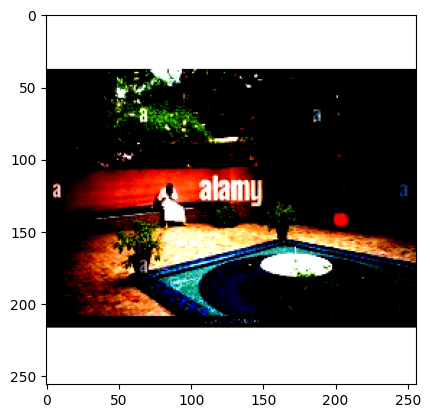

In [5]:
data = cc3m_dataset[100]
plt.imshow(data[0].permute(1,2,0))
print(len(data))
print(data[2])

In [6]:
import os
from copy import deepcopy

import pandas as pd
import torch
from PIL import Image
from torchvision.transforms import ToTensor

# 存在しない画像を除外するためのリスト
dropimageidlist = ["7f1934f5884fad79", "429019e83c1c2c94", "4f818c006da84c9e", "5b86e93f8654118a", "673d74b7d39741c3", "6dcd3ce37a17f2be", "805baf9650a12710"]


class OpenImageDataset_detection(torch.utils.data.Dataset):
    """openimageのdetectionデータセット"""

    def __init__(self, data_dir: str = "/data/dataset/openimage/", phase: str = "train", imagesize: tuple[int, int] = (256, 256)):
        if phase == "val":
            self.phase = "validation"
        else:
            self.phase = phase

        self.data_dir = data_dir
        self.imagesize = imagesize
        self.transform = ToTensor()
        self.not_exist_image = []

        datapath = os.path.join(data_dir, "bbox", f"{self.phase}_detection_40.csv")
        self.df = pd.read_csv(datapath)
        # dropimageidlistに含まれる画像を除外する
        self.df = self.df[self.df["imageID"].isin(dropimageidlist) == False]
        leabelpath = os.path.join(data_dir, "oidv7-class-descriptions.csv")
        self.labels = pd.read_csv(leabelpath)

    # def _return_loc(self,imsize:tuple[int,int],bbox: list[float,float,float,float])->tuple[int,int,int,int]:
    #     """locationを返す

    #     Parameters
    #     ----------
    #     imsize : tuple[int,int]
    #         画像のサイズ
    #     bbox : list[float,float,float,float]
    #         bboxの情報

    #     Returns
    #     -------
    #     x1,x2,y1,y2 : int,int,int,int
    #         locationのタプル
    #     """
    #     x1 = int(imsize[0]*bbox[0])
    #     x2 = int(imsize[0]*bbox[2])
    #     y1 = int(imsize[1]*bbox[1])
    #     y2 = int(imsize[1]*bbox[3])
    #     return x1,x2,y1,y2

    def __getitem__(self, index):
        data = self.df.iloc[index]
        imagepath = os.path.join(self.data_dir, self.phase, data["imageID"] + ".jpg")
        try:
            image = self.transform(Image.open(imagepath).convert("RGB").resize(self.imagesize))
        except:
            self.not_exist_image.append(imagepath)
            print(index,imagepath)
            image = None
        src_text = "What objects are in the image?"
        tgt_text = data["text"]
        return image, src_text, tgt_text

    def __len__(self):
        return len(self.df)

In [7]:

detection_dataset = OpenImageDataset_detection("/home/omote/gpu-node/openimage",phase="val")
print(len(detection_dataset))
print(isinstance(detection_dataset,torch.utils.data.IterableDataset))

36781
False


In [8]:
#11708/36786
#2000から一回回す
for i in tqdm(range(len(detection_dataset))):
    data = detection_dataset[i]

 60%|██████    | 22199/36781 [07:10<03:46, 64.48it/s] 

22187 /home/omote/gpu-node/openimage/validation/98ac2996fc46b56d.jpg


 65%|██████▌   | 23911/36781 [07:43<03:46, 56.77it/s]

23900 /home/omote/gpu-node/openimage/validation/a46a248a39f2d97c.jpg


100%|██████████| 36781/36781 [18:15<00:00, 33.58it/s] 


In [9]:
print(detection_dataset.not_exist_image)

['/home/omote/gpu-node/openimage/validation/98ac2996fc46b56d.jpg', '/home/omote/gpu-node/openimage/validation/a46a248a39f2d97c.jpg']


In [ ]:
detection_dataloader = torch.utils.data.DataLoader(detection_dataset,batch_size=1,shuffle=False,num_workers=1)
for data in tqdm(detection_dataloader):
    continue

  0%|          | 1/36786 [00:00<1:10:00,  8.76it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 32%|███▏      | 11708/36786 [08:58<19:14, 21.72it/s]  


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/omote/WorkSpace/KLab_MultiModalModel/multi_task_train/../data/detection/oidv7_detection.py", line 57, in __getitem__
    image = self.transform(Image.open(imagepath).convert("RGB").resize(self.imagesize))
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/PIL/Image.py", line 3280, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file '/home/omote/gpu-node/openimage/validation/4f818c006da84c9e.jpg'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
<loc_80> <loc_1277> Fixed-wing aircraft.


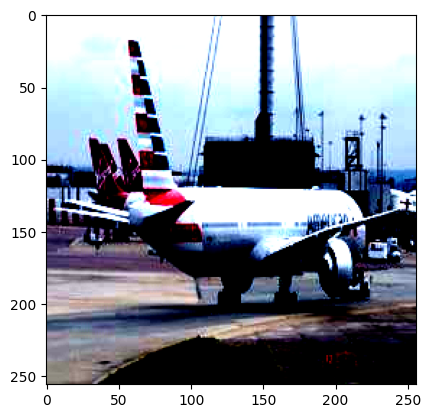

In [69]:
data = next(iter(detection_dataset))
additional_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
plt.imshow(additional_transforms(data[0]).permute(1,2,0))
print(len(data))
print(data[2])

In [65]:
vcr_dataset = data_module.vqa.vqa2.Vqa2dataset("/home/omote/gpu-node/vqa2",phase="val")
print(len(vqa_dataset))
print(isinstance(vqa_dataset,torch.utils.data.IterableDataset))

214354
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
platform


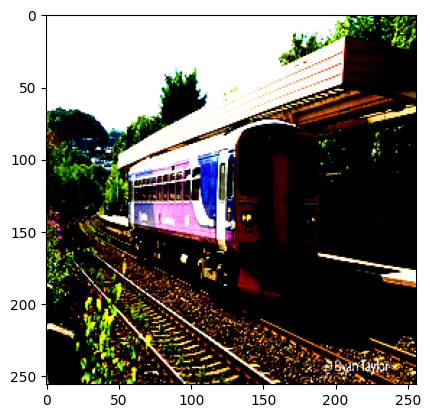

In [71]:
data = vqa_dataset[100]
import matplotlib.pyplot as plt
plt.imshow(additional_transforms(data[0]).permute(1,2,0))
print(len(data))
print(data[2])

In [62]:
coco_dataset = data_module.caption.COCODatasetLoader("/home/omote/gpu-node/mscoco2017",phase="val")
print(len(coco_dataset))
print(isinstance(coco_dataset,torch.utils.data.IterableDataset))

5000
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
None


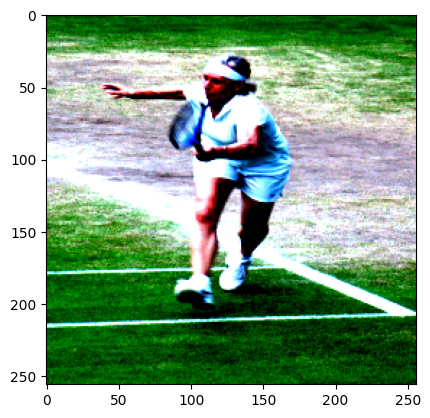

In [77]:
data = coco_dataset[100]
import matplotlib.pyplot as plt
plt.imshow(data[0].permute(1,2,0))
print(len(data))
print(data[1])

In [80]:
coco_dataloader = torch.utils.data.DataLoader(coco_dataset,batch_size=4,shuffle=True,num_workers=1)
next(iter(coco_dataloader))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/opt/pipenv/KLab_MultiModalModel-Zh2ecsZR/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>
